In [4]:
import numpy as np
import shap
n_features = 'all'
#term_pred = 'long_term'
data_file_name = 'data_for_training_tsfeatures_models'
endpt = 17
eval_times = np.r_[np.arange(1, endpt+1, 1)]
training_id_file_name = 'all_training_set_ID'
validation_id_file_name = 'all_validation_set_ID'
testing_id_file_name = 'all_testing_set_ID'
#work_dir = '/home/idies/workspace/Storage/hnguye78/persistent/CARDIA_longi_project/'
work_dir = 'U:/Hieu/CARDIA_longi_project/'

In [2]:
# %pip install tensorflow
# %pip install lifelines

#!y | pip uninstall statsmodels 
# %pip install statsmodels==0.11.0

# %pip install keras

In [2]:
import pkg_resources
#pkg_resources.require("scikit-learn==1.0.2")
import sklearn

import sksurv

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from numpy.random import seed

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

from sksurv.datasets import load_gbsg2
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest

In [5]:
load_dir = work_dir+ '/csv_files'

# load data:
data_full = pd.read_csv(load_dir+'/'+data_file_name+'.csv')
data_full = data_full.select_dtypes(include =[np.number])



In [22]:
# load training id:
loaddir = work_dir+ '/csv_files'
trainingid_all = pd.read_csv(loaddir+'/'+training_id_file_name+'.csv')
validationid_all = pd.read_csv(loaddir+'/'+validation_id_file_name+'.csv')
testingid_all = pd.read_csv(loaddir+'/'+testing_id_file_name+'.csv')


## no need to standardize feature space since RSF can handle it, then merge back to label space:
feature_space = data_full.drop(['ID','event','time'], axis = 1)
feature_name_list = feature_space.columns.values


In [7]:
data_full

,ID,event,time,AGE_Y15,MALE,RACEBLACK,SBP__quantile__q_0.9,HBM__quantile__q_0.8,HBM__last_location_of_minimum,SBP__abs_energy,...,SBP__change_quantiles__f_agg_.mean.__isabs_True__qh_0.8__ql_0.4,HBM__minimum,DIAB__percentage_of_reoccurring_datapoints_to_all_datapoints,SBP__change_quantiles__f_agg_.var.__isabs_False__qh_1.0__ql_0.4,SBP__change_quantiles__f_agg_.mean.__isabs_True__qh_1.0__ql_0.6,HBM__change_quantiles__f_agg_.mean.__isabs_False__qh_0.8__ql_0.4,SBP__has_duplicate,HBM__time_reversal_asymmetry_statistic__lag_1,DIAB__change_quantiles__f_agg_.mean.__isabs_True__qh_1.0__ql_0.4,DIAB__range_count__max_1__min_.1
0,1.000333e+11,0,17.134155,37,1,0,116.6,0.0,1.0,62844.0,...,0.0,0,1.0,0.000000,1.0,0.0,0,0.0,0.0,5
1,1.000565e+11,0,17.142368,43,1,1,142.0,0.0,1.0,96976.0,...,6.0,0,1.0,100.000000,26.0,0.0,0,0.0,0.0,6
2,1.000613e+11,0,17.427105,35,1,1,139.5,0.0,1.0,88147.0,...,6.5,0,1.0,429.555556,24.5,0.0,0,0.0,0.0,6
3,1.000801e+11,0,17.057495,35,1,1,117.5,0.0,1.0,75162.0,...,0.5,0,1.0,9.555556,3.5,0.0,1,0.0,0.0,6
4,1.001011e+11,0,17.424367,43,0,1,113.5,0.0,1.0,70978.0,...,3.0,0,1.0,6.000000,1.5,0.0,1,0.0,0.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3546,4.167520e+11,0,16.704310,41,1,1,116.0,0.0,1.0,75123.0,...,0.0,0,1.0,0.000000,3.0,0.0,0,0.0,0.0,6
3547,4.167612e+11,0,16.674200,45,0,0,118.5,0.0,1.0,67373.0,...,12.0,0,1.0,2.250000,10.5,0.0,1,0.0,0.0,6
3548,4.167833e+11,0,16.690620,42,0,0,112.5,0.0,1.0,47574.0,...,0.0,0,1.0,6.250000,2.5,0.0,1,0.0,0.0,4
3549,4.167962e+11,0,16.761810,42,0,1,111.0,0.2,1.0,54843.0,...,5.0,0,1.0,56.250000,0.0,0.0,0,0.0,0.0,5


In [38]:
def f_rsf_input_as_matrix(X):
    surv = rsf.predict_survival_function(X, return_array=True)
    last_yr_pred_prob_surv=surv[:,-1]
    return last_yr_pred_prob_surv


def vimp_shap_tabular(feature_names, vals):
    feature_importance_df = pd.DataFrame(list(zip(feature_names, vals)), columns=['variable_name','vimp'])
    feature_importance_df.sort_values(by=['vimp'], ascending=False,inplace=True)
    feature_importance_df['normalized_vimp'] = (feature_importance_df['vimp'] - min(feature_importance_df['vimp']))/(max(feature_importance_df['vimp'])-min(feature_importance_df['vimp']))
    
   # merge with variable description:
   # var_dict = pd.read_csv(load_dir+'/y5_all_vars_dictionary_manually_selecting_vars (3).csv', encoding= 'unicode_escape')
   # var_dict[['Variable.Name', 'Variable.Label']]
    ## merge vimp table with var dict to get var description:
    # feature_importance_df_with_vardes = feature_importance_df.merge(
    #    var_dict[['Variable.Name', 'Variable.Label']], how = 'inner', right_on= 'Variable.Name', left_on = 'variable_name', copy= False)
    return(feature_importance_df[['variable_name','normalized_vimp','vimp']])


In [24]:
eligible_id.shape

(2566,)

In [32]:
# Outerloop:
c_index = np.zeros((25,1))
# for fold in range(25):

## 
fold = 0
print('')
print('FOLD '+str(fold)+':')
print('')

# trainingid = trainingid_all.iloc[:,fold]
# trainingid = trainingid[~np.isnan(trainingid)]

trainingid = trainingid_all.iloc[:,fold].values
validationid = validationid_all.iloc[:,fold].values
testingid = testingid_all.iloc[:,fold].values

training_validation_id = np.concatenate([trainingid,validationid])
#training_validation_id = training_validation_id[~np.isnan(training_validation_id)]
#testingid = testingid[~np.isnan(testingid)]

#eligible_id = data_full['ID'][data_full['ID'].isin(training_validation_id)]
train_df = data_full.loc[data_full['ID'].isin(training_validation_id),:]
del train_df['ID']
test_df = data_full.loc[data_full['ID'].isin(testingid),:]
del test_df['ID']

featurespace_train_df = train_df.drop(['time','event'],axis =1)
featurespace_test_df = test_df.drop(['time','event'],axis =1)

featurespace_train = train_df.drop(['time','event'],axis =1).values
featurespace_test = test_df.drop(['time','event'],axis =1).values

y_train = sksurv.util.Surv.from_dataframe('event', 'time', train_df)
y_test = sksurv.util.Surv.from_dataframe('event', 'time', test_df)



FOLD 0:



In [33]:
featurespace_train_df

,AGE_Y15,MALE,RACEBLACK,SBP__quantile__q_0.9,HBM__quantile__q_0.8,HBM__last_location_of_minimum,SBP__abs_energy,SBP__c3__lag_2,HBM__first_location_of_maximum,SBP__standard_deviation,...,SBP__change_quantiles__f_agg_.mean.__isabs_True__qh_0.8__ql_0.4,HBM__minimum,DIAB__percentage_of_reoccurring_datapoints_to_all_datapoints,SBP__change_quantiles__f_agg_.var.__isabs_False__qh_1.0__ql_0.4,SBP__change_quantiles__f_agg_.mean.__isabs_True__qh_1.0__ql_0.6,HBM__change_quantiles__f_agg_.mean.__isabs_False__qh_0.8__ql_0.4,SBP__has_duplicate,HBM__time_reversal_asymmetry_statistic__lag_1,DIAB__change_quantiles__f_agg_.mean.__isabs_True__qh_1.0__ql_0.4,DIAB__range_count__max_1__min_.1
0,37,1,0,116.6,0.0,1.000000,62844.0,1314495.0,0.000000,4.979960,...,0.0,0,1.0,0.000000,1.0,0.0,0,0.0,0.0,5
2,35,1,1,139.5,0.0,1.000000,88147.0,1694120.0,0.000000,18.197222,...,6.5,0,1.0,429.555556,24.5,0.0,0,0.0,0.0,6
6,34,0,1,109.5,0.0,0.833333,67259.0,1184084.5,0.833333,3.023060,...,5.0,0,1.0,4.000000,1.0,0.0,0,0.0,0.0,6
8,38,0,1,109.6,0.0,1.000000,33953.0,0.0,0.000000,3.299832,...,0.0,0,1.0,12.250000,0.0,0.0,1,0.0,0.0,3
9,42,0,0,99.6,0.0,1.000000,43769.0,861696.0,0.000000,5.499091,...,2.0,0,0.8,25.000000,0.0,0.0,0,0.0,0.5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3545,42,1,1,117.5,0.0,1.000000,74733.0,1382458.0,0.000000,4.821825,...,2.0,0,1.0,81.555560,0.0,0.0,1,0.0,0.0,6
3547,45,0,0,118.5,0.0,1.000000,67373.0,1159434.0,0.000000,9.928914,...,12.0,0,1.0,2.250000,10.5,0.0,1,0.0,0.0,6
3548,42,0,0,112.5,0.0,1.000000,47574.0,0.0,0.000000,3.535534,...,0.0,0,1.0,6.250000,2.5,0.0,1,0.0,0.0,4
3549,42,0,1,111.0,0.2,1.000000,54843.0,1019700.0,0.000000,5.238320,...,5.0,0,1.0,56.250000,0.0,0.0,0,0.0,0.0,5


In [34]:
featurespace_test_df

,AGE_Y15,MALE,RACEBLACK,SBP__quantile__q_0.9,HBM__quantile__q_0.8,HBM__last_location_of_minimum,SBP__abs_energy,SBP__c3__lag_2,HBM__first_location_of_maximum,SBP__standard_deviation,...,SBP__change_quantiles__f_agg_.mean.__isabs_True__qh_0.8__ql_0.4,HBM__minimum,DIAB__percentage_of_reoccurring_datapoints_to_all_datapoints,SBP__change_quantiles__f_agg_.var.__isabs_False__qh_1.0__ql_0.4,SBP__change_quantiles__f_agg_.mean.__isabs_True__qh_1.0__ql_0.6,HBM__change_quantiles__f_agg_.mean.__isabs_False__qh_0.8__ql_0.4,SBP__has_duplicate,HBM__time_reversal_asymmetry_statistic__lag_1,DIAB__change_quantiles__f_agg_.mean.__isabs_True__qh_1.0__ql_0.4,DIAB__range_count__max_1__min_.1
1,43,1,1,142.0,0.0,1.0,96976.0,1982806.5,0.0,14.232201,...,6.0,0,1.0,100.000000,26.0,0.0,0,0.0,0.0,6
3,35,1,1,117.5,0.0,1.0,75162.0,1390800.0,0.0,7.586538,...,0.5,0,1.0,9.555556,3.5,0.0,1,0.0,0.0,6
4,43,0,1,113.5,0.0,1.0,70978.0,1281672.0,0.0,4.606758,...,3.0,0,1.0,6.000000,1.5,0.0,1,0.0,0.0,6
5,34,1,1,155.3,0.8,0.5,40165.0,0.0,0.5,18.500000,...,0.0,0,1.0,0.000000,0.0,0.0,0,0.0,0.0,2
7,45,0,0,107.5,0.0,1.0,62162.0,1048896.0,0.0,4.921608,...,3.0,0,1.0,9.000000,3.0,0.0,1,0.0,0.8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3520,39,0,0,104.6,0.0,1.0,48787.0,952300.0,0.0,5.953150,...,1.0,0,1.0,6.250000,6.0,0.0,0,0.0,0.0,5
3522,44,0,1,127.2,0.0,1.0,62453.0,1366800.0,0.0,13.023060,...,7.5,0,1.0,57.555560,17.0,0.0,1,0.0,0.0,5
3526,42,0,1,106.4,0.0,1.0,51493.0,1058400.0,0.0,4.079216,...,4.0,0,1.0,0.000000,4.0,0.0,0,0.0,0.0,5
3531,43,0,0,106.6,0.0,1.0,48875.0,892492.0,0.0,7.282857,...,0.0,0,1.0,0.000000,0.0,0.0,0,0.0,0.0,5


In [36]:

##########################
# Build model:


seed(1)
rsf = RandomSurvivalForest(n_estimators=1001,
                       min_samples_split=10,
                       min_samples_leaf=15,
                       max_features="sqrt",
                       n_jobs=-1,
                       random_state=20)
rsf.fit(featurespace_train_df, y_train) 

rsf.score(featurespace_test_df, y_test) 
c_index[fold] = rsf.score(featurespace_test_df, y_test) 

savedir = os.path.join(work_dir,'csv_files/rsf_tsfresh/'+str(n_features)+'_features/')
try: 
    os.makedirs(savedir)
except OSError:
    if not os.path.isdir(savedir):
        raise
actual_fold = fold+1


## SHAP:

X_train_df_summary = shap.kmeans(featurespace_train_df, 10)
explainer_kmeans = shap.KernelExplainer(f_rsf_input_as_matrix, X_train_df_summary, feature_names=feature_name_list) 
kmeans_shaps = explainer_kmeans.shap_values(featurespace_test_df)



KeyError: "['Variable.Name'] not in index"

In [39]:
vimp_shap_kmeans = vimp_shap_tabular(feature_name_list, np.abs(kmeans_shaps).mean(0))

vimp_shap_kmeans.to_csv(savedir+'/shap_kernel_explainer_fold_'+str(actual_fold)+'.csv', index = None, header = True)


In [58]:
pd.DataFrame(kmeans_shaps).to_csv(savedir+'/all_kmeans_shap_values_fold_'+str(actual_fold)+'.csv', index = None, header = True)

In [59]:
explainer_kmeans

In [92]:
explainer_kmeans.expected_value
# pd.DataFrame(explainer_kmeans.expected_value).to_csv(savedir+'/explainer_kmeans_expected_values_fold_'+str(actual_fold)+'.csv', index = None, header = True)
with open(savedir+'/explainer_kmeans_expected_values_fold_'+str(actual_fold)+'.txt', 'w') as f:
    f.write(str(explainer_kmeans.expected_value))


In [87]:
import pickle 
file_explainer_kmeans = open(savedir+'/'+'file_explainer_kmeans.obj', 'wb') 
pickle.dump(explainer_kmeans, file_explainer_kmeans)



PicklingError: Can't pickle <function f_rsf_input_as_matrix at 0x00000183B9B31040>: it's not the same object as __main__.f_rsf_input_as_matrix

In [50]:
import pickle 

load_kmeans_shaps = pickle.load(open(savedir+'/'+'file_kmeans_shaps.obj', 'r'))

UnicodeDecodeError: 'charmap' codec can't decode byte 0x8f in position 344: character maps to <undefined>

In [55]:
kmeans_shaps.shape

(636, 127)

In [53]:
shap.plots.bar(kmeans_shaps.abs.mean(0))


AttributeError: 'numpy.ndarray' object has no attribute 'abs'

In [64]:
explainer_kmeans.expected_value

0.974884215377668

In [66]:
shap.initjs()
shap.force_plot(explainer_kmeans.expected_value, kmeans_shaps[0],featurespace_test_df.iloc[0,:])


In [81]:
# shap.initjs()
# # shap.plots.waterfall(explainer_kmeans, kmeans_shaps[0],featurespace_test_df.iloc[0,:])
# shap.plots.waterfall(kmeans_shaps[0])


AttributeError: 'numpy.ndarray' object has no attribute 'base_values'

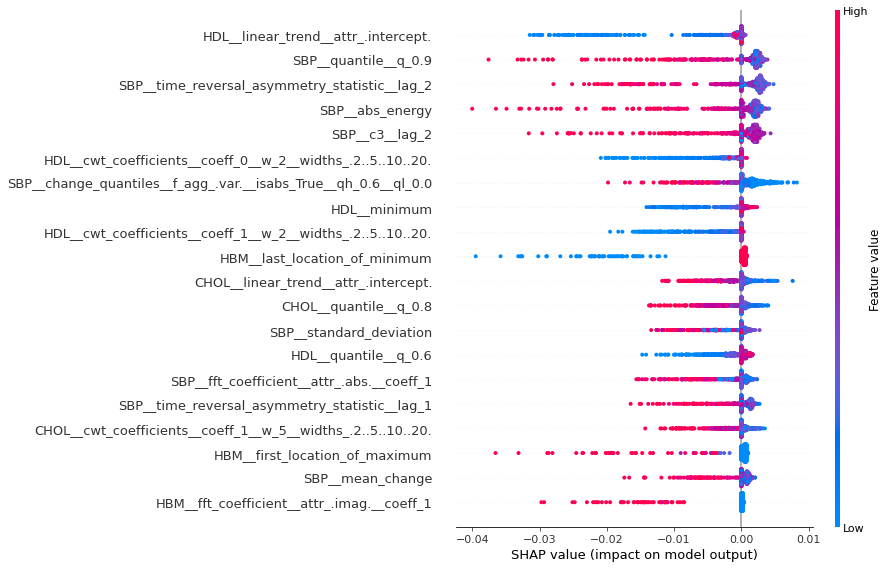

In [69]:
shap.initjs()
shap.summary_plot(kmeans_shaps, featurespace_test_df.iloc[:,:])


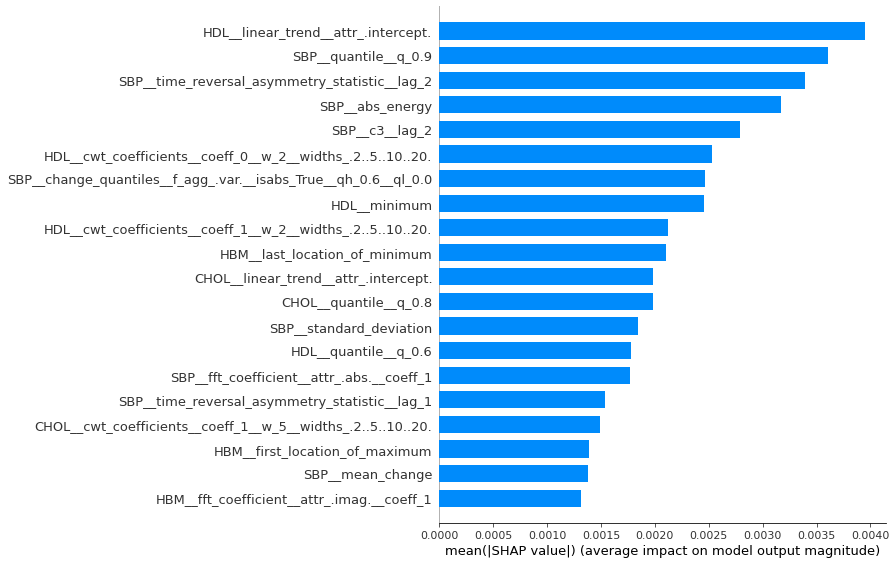

In [94]:
# shap.initjs()

shap.summary_plot(kmeans_shaps, featurespace_test_df.iloc[:,:], plot_type = 'bar')


In [123]:
vimp_shap_kmeans.variable_name[:20].values

array(['HDL__linear_trend__attr_.intercept.', 'SBP__quantile__q_0.9',
       'SBP__time_reversal_asymmetry_statistic__lag_2', 'SBP__abs_energy',
       'SBP__c3__lag_2',
       'HDL__cwt_coefficients__coeff_0__w_2__widths_.2..5..10..20.',
       'SBP__change_quantiles__f_agg_.var.__isabs_True__qh_0.6__ql_0.0',
       'HDL__minimum',
       'HDL__cwt_coefficients__coeff_1__w_2__widths_.2..5..10..20.',
       'HBM__last_location_of_minimum',
       'CHOL__linear_trend__attr_.intercept.', 'CHOL__quantile__q_0.8',
       'SBP__standard_deviation', 'HDL__quantile__q_0.6',
       'SBP__fft_coefficient__attr_.abs.__coeff_1',
       'SBP__time_reversal_asymmetry_statistic__lag_1',
       'CHOL__cwt_coefficients__coeff_1__w_5__widths_.2..5..10..20.',
       'HBM__first_location_of_maximum', 'SBP__mean_change',
       'HBM__fft_coefficient__attr_.imag.__coeff_1'], dtype=object)

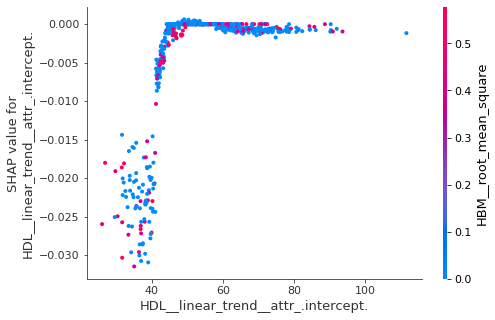

In [117]:
shap.dependence_plot("HDL__linear_trend__attr_.intercept.", kmeans_shaps, featurespace_test_df) #,interaction_index=None)


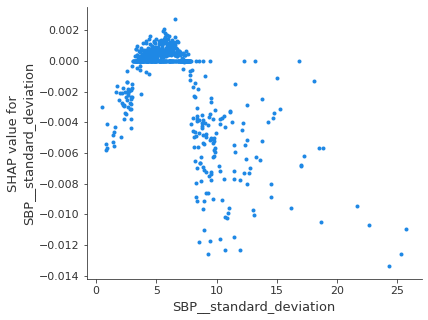

In [112]:
shap.dependence_plot("SBP__standard_deviation", kmeans_shaps, featurespace_test_df,interaction_index=None)


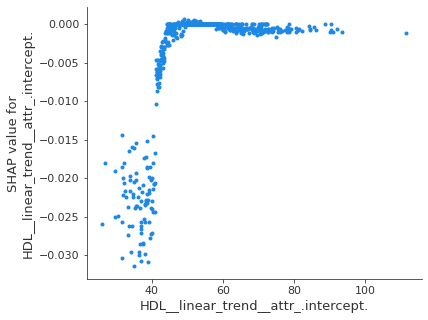

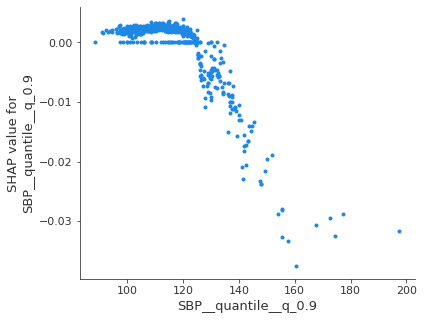

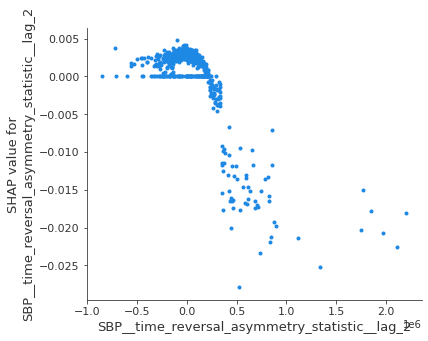

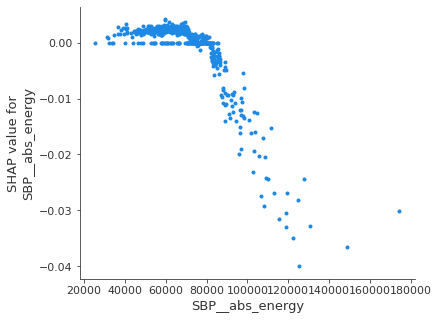

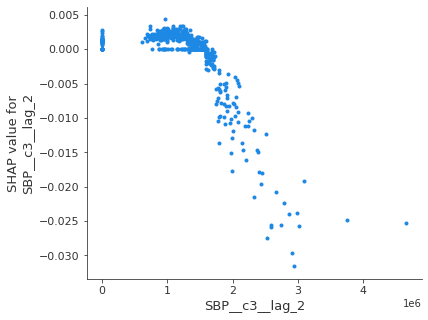

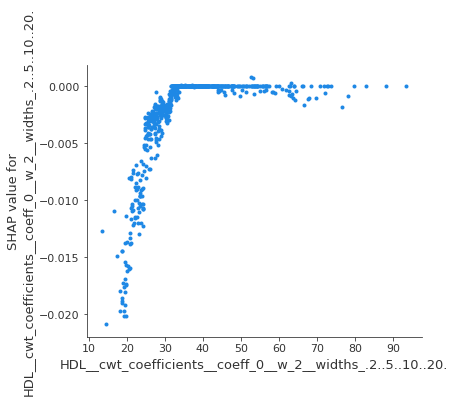

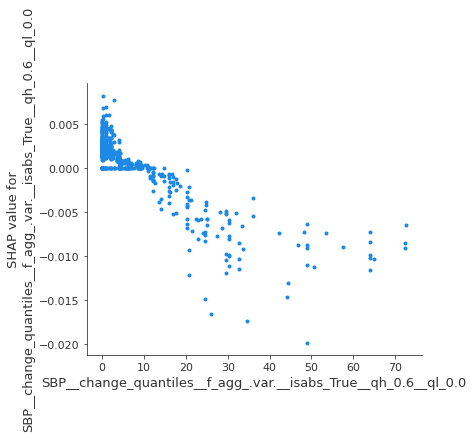

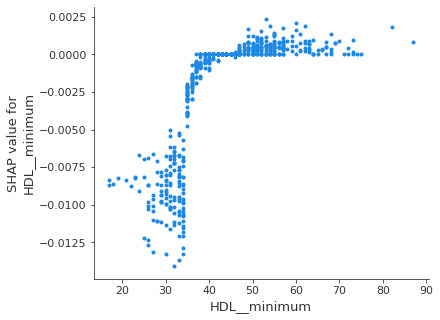

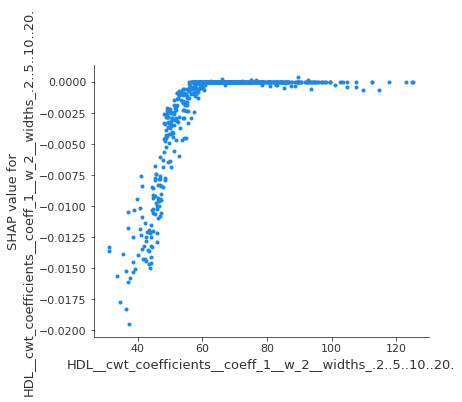

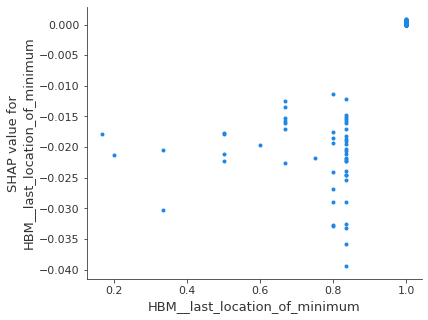

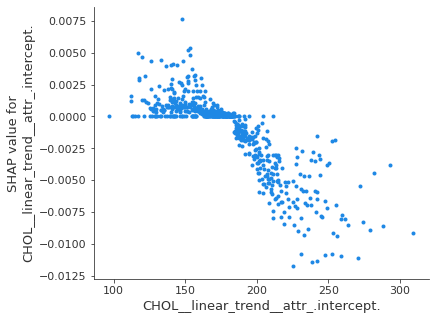

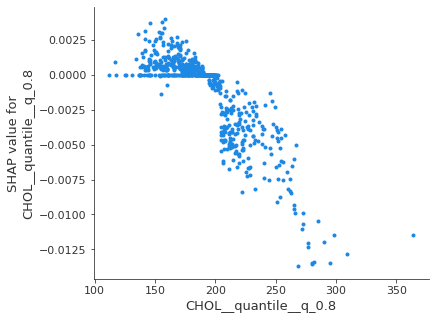

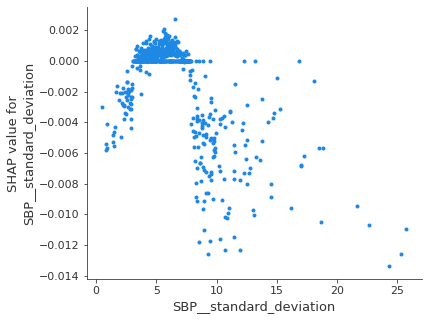

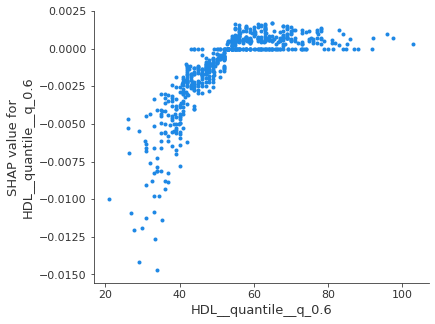

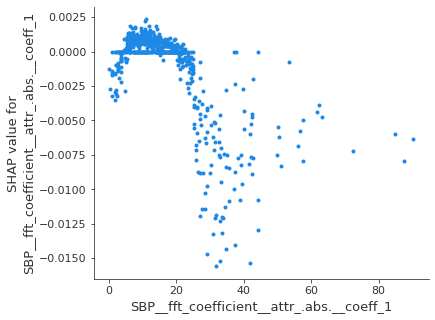

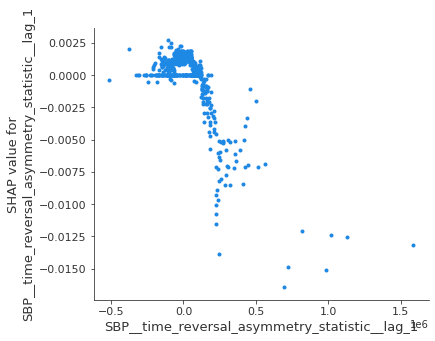

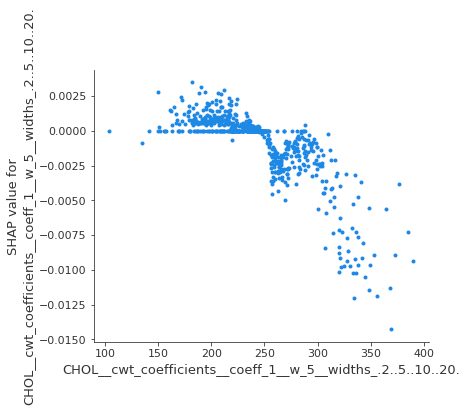

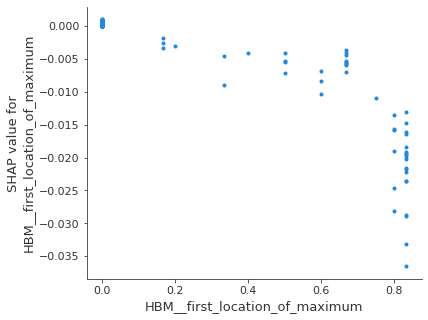

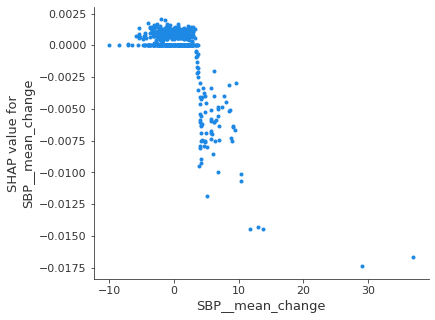

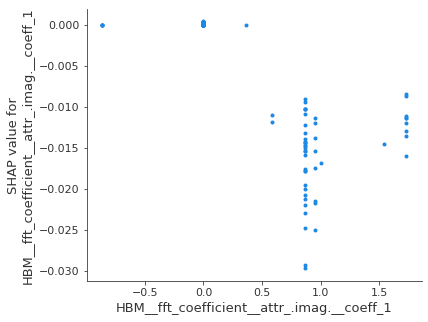

In [124]:
top_n_var = 20
top_var_names_arr = vimp_shap_kmeans.variable_name[:top_n_var].values
for i in range(top_n_var):
    var_oi = top_var_names_arr[i]
    shap.dependence_plot(var_oi, kmeans_shaps, featurespace_test_df,interaction_index=None)



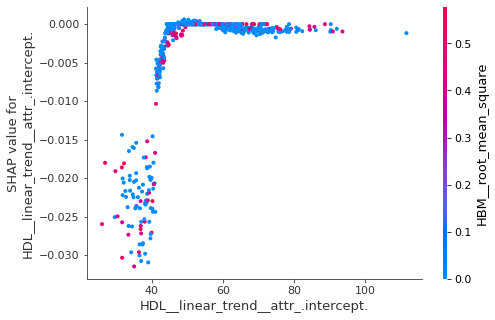

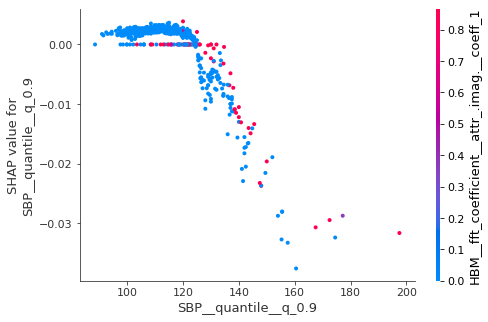

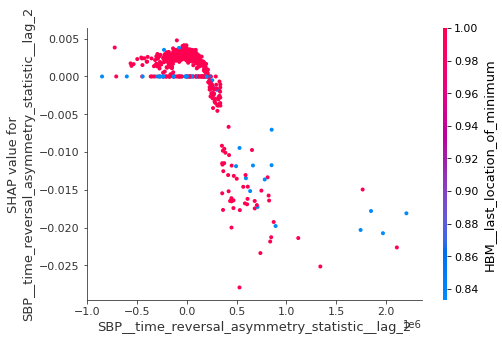

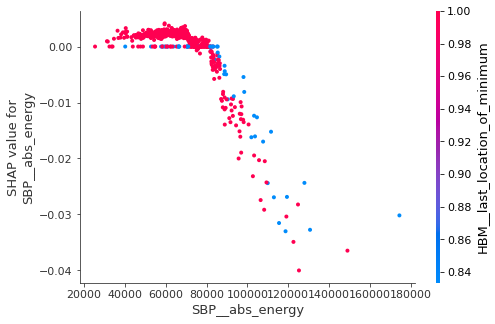

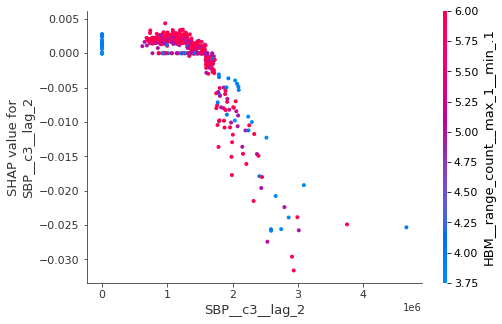

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


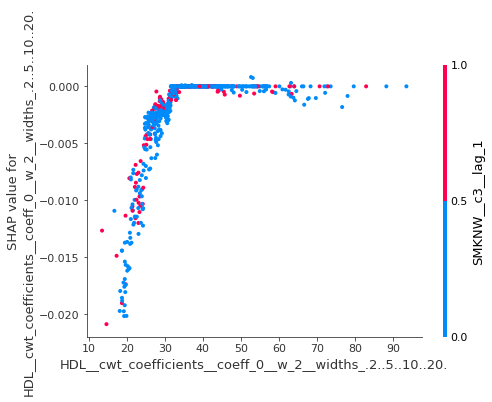

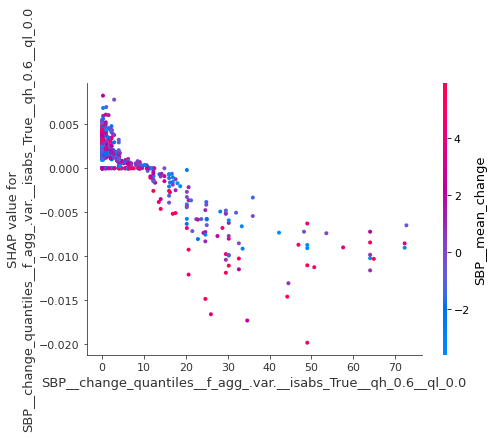

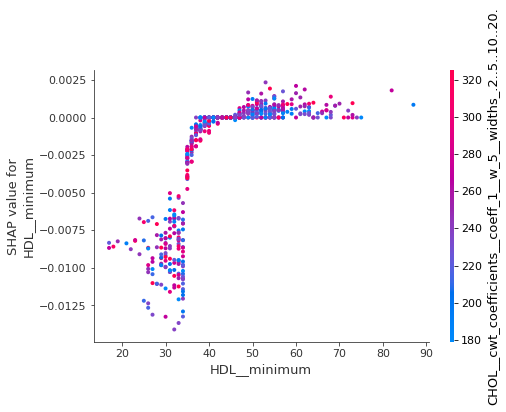

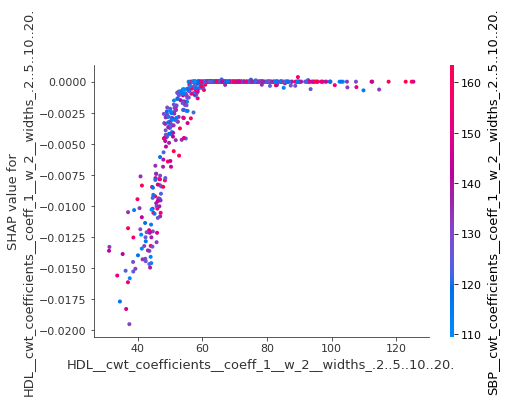

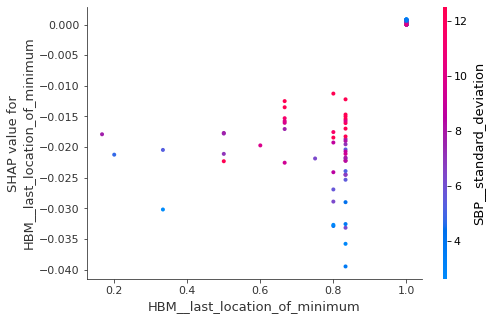

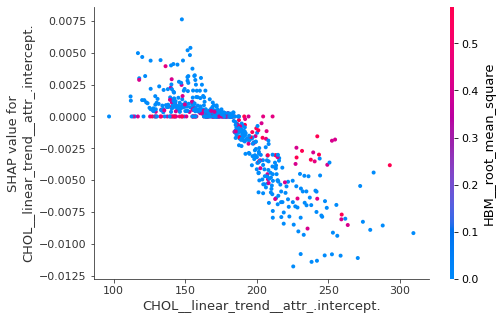

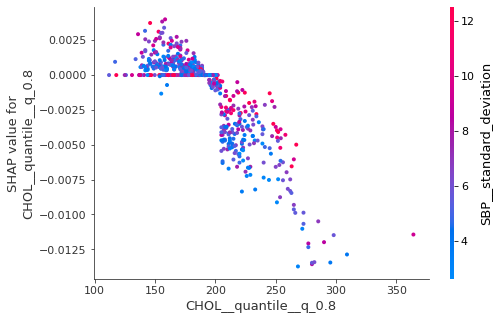

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


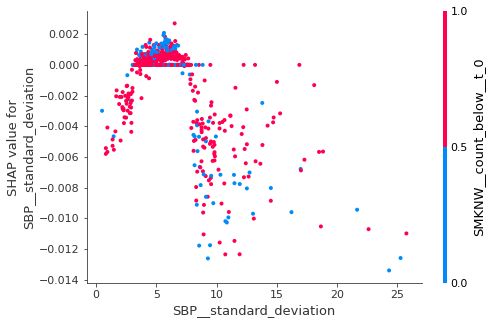

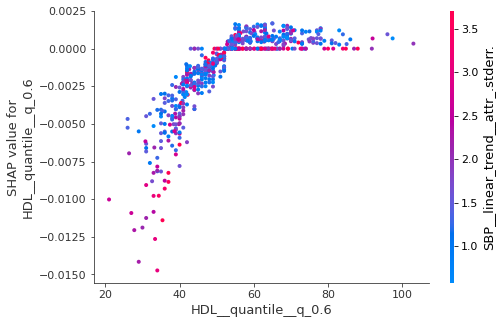

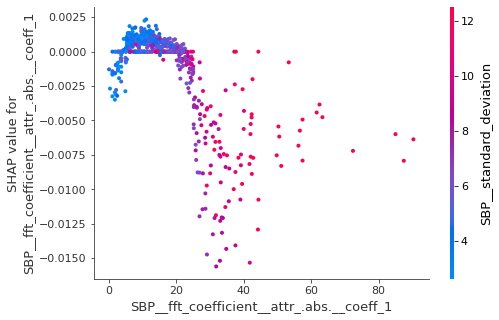

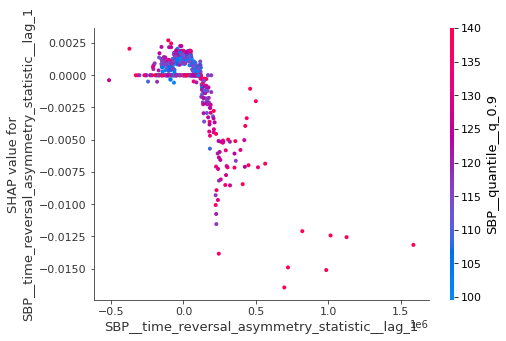

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


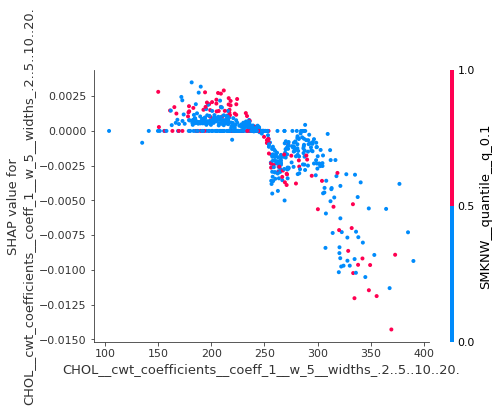

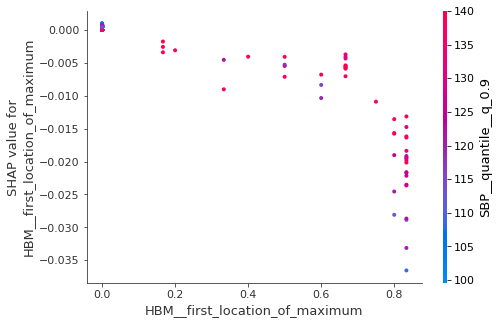

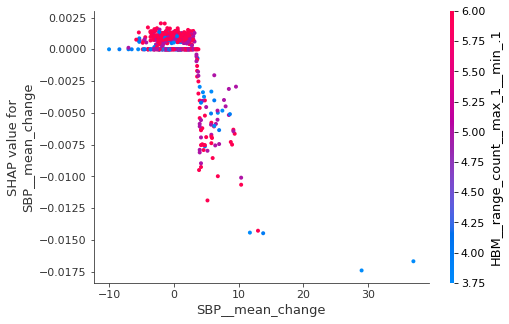

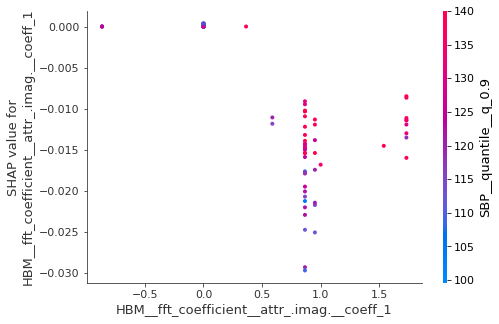

In [125]:
top_n_var = 20
top_var_names_arr = vimp_shap_kmeans.variable_name[:top_n_var].values
for i in range(top_n_var):
    var_oi = top_var_names_arr[i]
    shap.dependence_plot(var_oi, kmeans_shaps, featurespace_test_df)

